In [5]:
import numpy as np
import random
from scipy.linalg import expm

from lib.gramians import Make
from lib.plotting import plot_eig, plot_W
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n_e = 150*2 # number of excitatory neurons
n_i = 50 *2 # number of inhibitory neurons
n = n_e + n_i  # number of neurons
p = 0.1 # exc. connection density
radius = 1.1 # spectral radius
dc_eval = -10 # eigenvalue of DC mode
e = slice(0,None),slice(0,n_e) 
i = slice(0,None),slice(n_e,None) 

## Initialising the connectivity matrix

In [3]:
def normalise(W):
    W[i] = np.minimum(0, W[i])
    z = (dc_eval - np.sum(W, axis=1).reshape(-1,1)) / n_i
    W[i] = np.minimum(0, z + W[i])
    W = W - np.diag(np.diag(W))
    #np.fill_diagonal(W, 0)
    return W

In [4]:
def initialise(n, p, radius):
    w0 = radius / np.sqrt(p * (1-p) * n) 
    # initialise connectivity matrix with the right density
    W = np.random.lognormal(np.log(w0),0.5,size=[n,n])
    #build adjacency matrix of connections
    adjacency = np.random.uniform(0,1,size=[n,n_e])
    adjacency[adjacency>p] = 2
    adjacency[adjacency<=p] = 1
    adjacency[adjacency>1] = 0
    W[e] = W[e] * adjacency # remove silence percent of the synapses
    W[i] = -np.random.rand(n,n_i)
    W = W - np.diag(np.diag(W)) # remove self connections 
    W = normalise(W)
    return W

## Optimize

In [5]:
def soc_function(W, eta, threshold):
    for step in range(n_iter):
        Emax = np.max(np.linalg.eig(W)[0].real)
        if Emax < threshold: 
            print("FINAL spectral abscissa  %f" % Emax)
            W_evals, _ = np.linalg.eig(W)
            plot_eig(W)
            break    
        shift = max(Emax*1.5, Emax + 0.2)
        A = W - shift * np.eye(n)
        Q = Make(A,None).O.m # observability gramian
        P = Make(A,None).C.m
        QP = Q.dot(P)
        dW = QP / np.trace(QP) # gradient of smoothed spectral abscissa with respect to W
        W[i]  = W[i] - rate * dW[i]
        W = normalise(W)
        np.fill_diagonal(W, 0)
        if (step % plot_every) == 0:
            plot_eig(W)
            print("step %3i | spectral abscissa  %f " % ((step,Emax)))
    return W

In [6]:
# random
np.random.seed(2023)
W = np.random.randn(n,n)/(n)**0.5
isn_name = 'random.txt'
np.savetxt(isn_name,W)
np.max(np.linalg.eig(W)[0].real)

0.9917632137239806

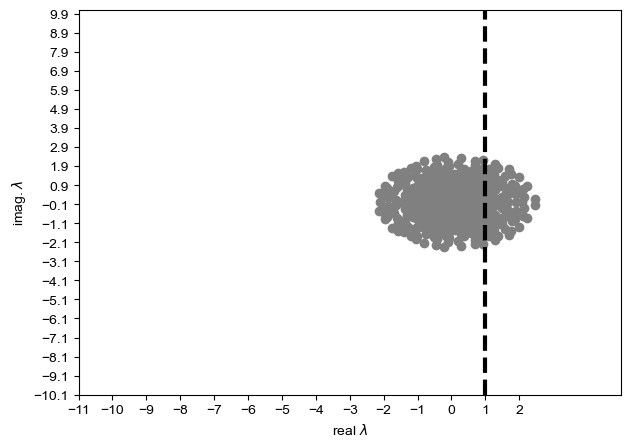

step   0 | spectral abscissa  2.798551 
FINAL spectral abscissa  0.797288


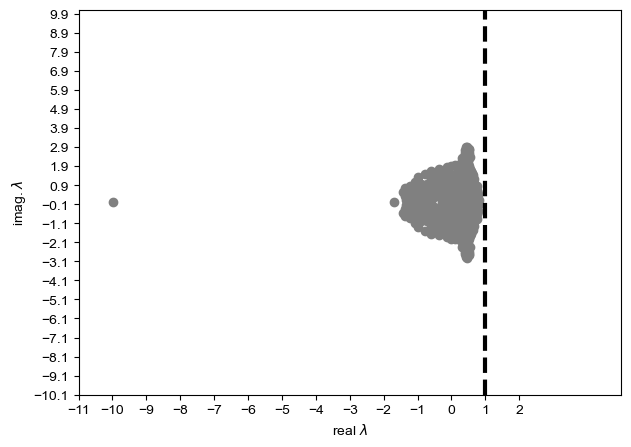

In [6]:
%matplotlib inline 
n_iter = 5001 # number of training steps
threshold = 0.8 # stop optimization when spectral abscissa lower than threshold 
plot_every = 600  # optimisation flags
rate=10 #learning rate

np.random.seed(2023)
W = initialise(n, p, 1.2)
W=soc_function(W, rate, threshold)

np.max(np.linalg.eig(W)[0].imag)
isn_name = 'isn_1.2_0.9.txt'
np.savetxt(isn_name,W)

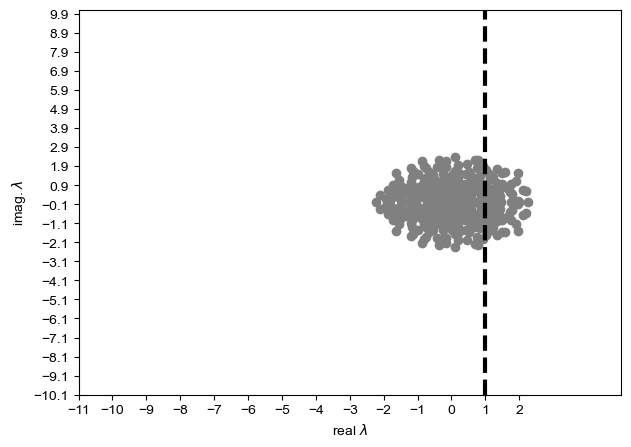

step   0 | spectral abscissa  2.597574 
FINAL spectral abscissa  0.797837


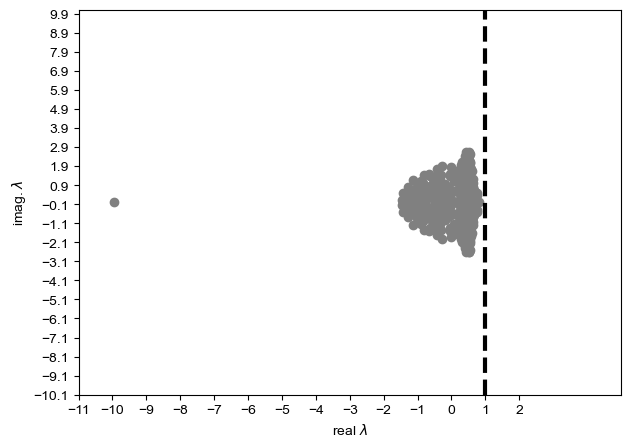

In [12]:
%matplotlib inline 
n_iter = 5001 # number of training steps
threshold = 0.8 # stop optimization when spectral abscissa lower than threshold 
plot_every = 600  # optimisation flags
rate=10 #learning rate

np.random.seed(2023)
W = initialise(n, p, 1.2)
W=soc_function(W, rate, threshold)

np.max(np.linalg.eig(W)[0].imag)
isn_name = 'isn_1.2_0.8.txt'
np.savetxt(isn_name,W)

# analysis

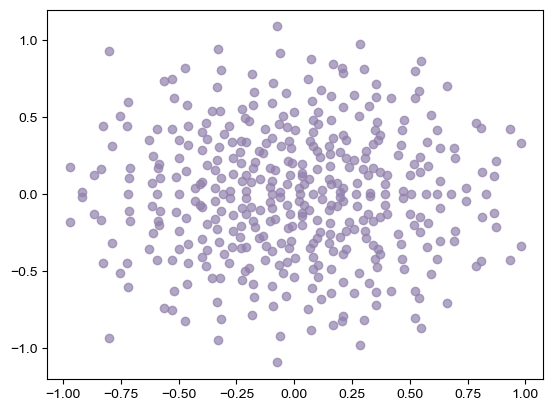

0.9799037842752465 1.0910007025071977


In [60]:
np.random.seed(2024)
p = 0.2
w0 = 1 / np.sqrt(p * (1-p) * n) 
f = n_e / n
# initialise connectivity matrix with the right density
we = w0*np.sqrt((1-f) / f) 
wi = w0*np.sqrt(f / (1-f)) 
#build adjacency matrix of connections
adjacency = np.random.uniform(0,1,size=[n,n])
adjacency[adjacency>p] = 2
adjacency[adjacency<=p] = 1
adjacency[adjacency>1] = 0
W[e] = we * adjacency[e] # remove silence percent of the synapses
W[i] = -wi * adjacency[i]
# W = W - np.diag(np.diag(W)) # remove self connections 
W_evals_12, _ = np.linalg.eig(W)
plt.plot(W_evals_12.real, W_evals_12.imag,'o', alpha=0.7, color='#9180AC', label='After')
plt.show()
print(W_evals_12.real.max(),W_evals_12.imag.max())

np.savetxt('w0.txt',W)

In [3]:
w_s = np.loadtxt('random.txt')
w_w = np.loadtxt('isn_1.2_0.9.txt')
w0 = np.loadtxt('w0.txt')

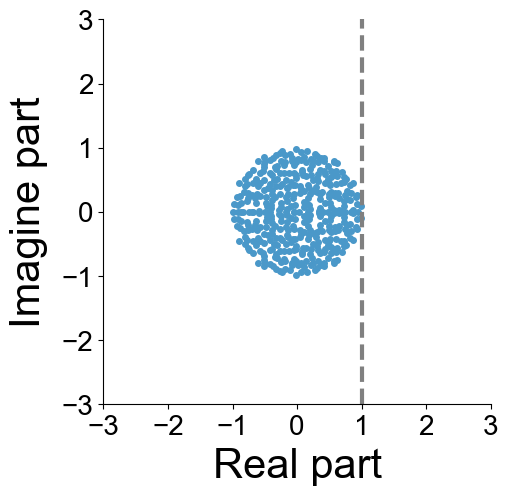

In [27]:
import seaborn as sns
c = sns.color_palette("YlGnBu_r", 9)[::2]
# cc=sns.color_palette("Purples", 3)
cc=sns.color_palette("Blues", 4)[1:]
plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(5,5))

W_evals_12, _ = np.linalg.eig(w_s)
plt.plot(W_evals_12.real, W_evals_12.imag,'o', ms=4, color=cc[1], label='After')

plt.ylim(-3,3)
plt.xlim(-3,3)
plt.xticks(np.arange(-3, 3.1, 1))
plt.yticks(np.arange(-3, 3.1, 1))
plt.axvline(x=1,linewidth=3, color='grey', linestyle="--")

ax=plt.gca()  #gca:get current axis得到当前轴
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('Real part', fontsize=30, labelpad=5)
plt.ylabel('Imagine part', fontsize=30, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), prop={'size': 25}, handlelength=1.5, handletextpad=0) 
plt.savefig('cca/spectrum_random.jpg', dpi=600, bbox_inches="tight")

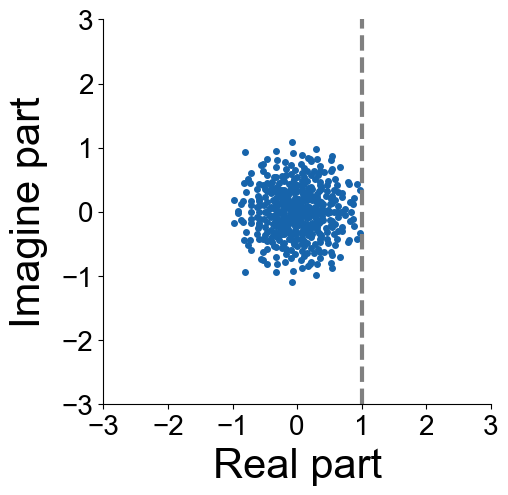

In [28]:
plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(5,5))

W_evals_12, _ = np.linalg.eig(w0)
plt.plot(W_evals_12.real, W_evals_12.imag,'o', ms=4, color=cc[2], label='After')

plt.ylim(-3,3)
plt.xlim(-3,3)
plt.xticks(np.arange(-3, 3.1, 1))
plt.yticks(np.arange(-3, 3.1, 1))
plt.axvline(x=1,linewidth=3, color='grey', linestyle="--")

ax=plt.gca()  #gca:get current axis得到当前轴
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('Real part', fontsize=30, labelpad=5)
plt.ylabel('Imagine part', fontsize=30, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), prop={'size': 25}, handlelength=1.5, handletextpad=0) 
plt.savefig('cca/spectrum_w0.jpg', dpi=600, bbox_inches="tight")

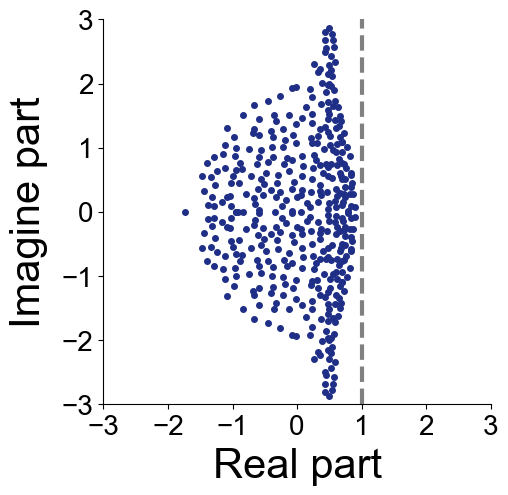

In [48]:
c = sns.color_palette("YlGnBu_r", 9)[::2]
cc=sns.color_palette("Blues_r", 2)

plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(5,5))

W_evals_12, _ = np.linalg.eig(w_w)
plt.plot(W_evals_12.real, W_evals_12.imag,'o', ms=4, color=c[0], label='After')
# plt.plot(W_evals_12.real, W_evals_12.imag,'o', alpha=0.7, color=cc[-1], label='After')

plt.ylim(-3,3)
plt.xlim(-3,3)
plt.xticks(np.arange(-3, 3.1, 1))
plt.yticks(np.arange(-3, 3.1, 1))
plt.axvline(x=1,linewidth=3, color='grey', linestyle="--")

ax=plt.gca()  #gca:get current axis得到当前轴
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('Real part', fontsize=30, labelpad=5)
plt.ylabel('Imagine part', fontsize=30, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1), prop={'size': 25}, handlelength=1.5, handletextpad=0) 
plt.savefig('cca/spectrum_isn.jpg', dpi=600, bbox_inches="tight")